# Análise Exploratória dos dados para X-Health

- Autora: Natália de Faria

## Importando bibliotecas

In [1]:
#adicionando retorno no diretório ao caminho
import sys
sys.path.append('../')

#ignorar warnings 
import warnings
warnings.filterwarnings('ignore')

from x_health.config import *
from x_health.utils import *

#adicionando arquivos locais

from x_health.plots  import correlation_heatmap

#from src.globals import *
#from src.eda import *
#from src.plots import *
#from src.auxiliar_xhealth import *

2025-02-05 23:24:07.160 | INFO     | x_health.config:<module>:11 - PROJ_ROOT path is: C:\Users\Natalia\OneDrive\Documentos\PROJETOS\Kognita\x_health


In [2]:
import pandas as pd 
import numpy as np

import pytz
import time
import gc

from loguru import logger
import csv
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

from scipy.stats import chi2_contingency

from scipy import stats

In [3]:
#mostrar todas as colunas
pd.set_option('display.max_columns',None)

### Importando base

In [4]:
#importando a base do arquivo externo
nome_base = f'{EXTERNAL_DATA_DIR}/dataset_2021-5-26-10-14.csv'
df = pd.read_csv(nome_base, sep = '\t' ,encoding = 'utf-8')
logger.info(f'Base importada com tamanho: {len(df)}')

2025-02-05 23:24:11.459 | INFO     | __main__:<module>:4 - Base importada com tamanho: 117273


In [5]:
df.head(3)

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,participacao_falencia_valor,dividas_vencidas_valor,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
0,0,58.000000,18.236092,0.00,0.0,242100.70,0,0.0,0,0.0,0.0,0.0,0,0,empresario (individual),simples nacional,papelaria,30/60/90,34665.674938,6,2019,0
1,1,16.052632,7.500000,224132.85,0.0,4960846.21,0,0.0,0,0.0,0.0,0.0,0,0,sociedade empresaria limitada,missing,com de equipamentos de informatica,30/60/90,7134.489373,10,2018,0
2,0,13.250000,3.904762,513043.83,0.0,158631.93,1,1800.0,0,0.0,0.0,0.0,0,0,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,missing,72653.621143,4,2018,0


## Setando variáveis e calculando taxas de evento e não evento

In [6]:
# cores personalizadas 
COR_1 = "#b11a6c" #rosa
COR_2 = "#373d7a" #azul escuro
COR_3 = "#6e446b" #roxo escuro
COR_CINZA = "#999999"

In [7]:
#setando variáveis de interesse
flag_inadimplencia = df['default'].astype(int)
inadimplencia = 'default'

# taxa de inadimpência na base
taxa_inadimplencia = df[inadimplencia].mean()
evento = df[inadimplencia].sum()
nao_evento = len(df) - evento

logger.info(f'Avaliando conceito de inadimplencia na base:')
print(f'Na base temos {evento} casos de inadimplência e {nao_evento} de não eventos')
print(f'Esses valores geram uma taxa base de inadimplência de {taxa_inadimplencia}')
print(f'Então, um evento é uma inadimplência a cada {round(1/taxa_inadimplencia)} analisados, aproximadamente')

2025-02-05 23:24:11.559 | INFO     | __main__:<module>:10 - Avaliando conceito de inadimplencia na base:
Na base temos 19545 casos de inadimplência e 97728 de não eventos
Esses valores geram uma taxa base de inadimplência de 0.16666240311069044
Então, um evento é uma inadimplência a cada 6 analisados, aproximadamente


In [8]:
print('Media de inadimplência nos anos: ')
df.groupby('year')[inadimplencia].mean()

Media de inadimplência nos anos: 


year
2017    0.133478
2018    0.189044
2019    0.164740
Name: default, dtype: float64

In [9]:
# Definir colunas numéricas e categóricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

## Análise de missings na base

In [10]:
# Substituindo "missing" por NaN
df.replace("missing", pd.NA, inplace=True)

In [11]:
# Valores ausentes
total_missing = df.isna().sum()
percentual_missing = (total_missing / len(df)) * 100

In [12]:
# DF com os resultados
missing_df = pd.DataFrame({
    'Coluna': df.columns,
    'Valores Faltantes': percentual_missing.values,
    'Percentual (%)': percentual_missing.values
})

In [13]:
# Filtrar ausentes
missing_df = missing_df[missing_df["Valores Faltantes"] > 0]

In [14]:
# Exibir os resultados
print(missing_df.sort_values(by="Percentual (%)", ascending=False))

                 Coluna  Valores Faltantes  Percentual (%)
17      forma_pagamento          27.693501       27.693501
15     opcao_tributaria          15.625933       15.625933
14       tipo_sociedade           0.518448        0.518448
16  atividade_principal           0.504805        0.504805


- alto valor de missing em forma_pagamento, possíveis causas:
    - erro de preenchimento
    - clientes novos sem histórico
    - erro na coleta (ex: campo não obrigatório)
- To do:
    - analisar impacto na correlação com inadimplência

- alta taxa de missings em opção_tribuitaria, possíveis causas:
    - Falta de informação na compra
    - problema de integração (?)

## Análise de Outliers

### Z-Score

In [15]:
# Calcular o Z-Score
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Identificar outliers (Z > 3)
outliers_z = (z_scores > 3)

# Contar quantos outliers existem por coluna e transformar em Series
outliers_z_count = pd.Series(outliers_z.sum(axis=0), index=numeric_cols)

# Ordenar os resultados
print(outliers_z_count[outliers_z_count > 0].sort_values(ascending=False))

ioi_3months                2649
ioi_36months               2169
default_3months            1533
valor_quitado               974
valor_por_vencer            762
quant_acao_judicial         413
dividas_vencidas_qtd        235
valor_vencido               188
valor_total_pedido          171
valor_protestos             112
quant_protestos              69
acao_judicial_valor          58
falencia_concordata_qtd      54
dividas_vencidas_valor       11
dtype: int64


podem conter outliers relevantes para a modelagem
ioi_3months
ioi_36months
default_3months
valor_quitado
valor_por_vencer
quant_acao_judicial

### Regra do Intervalo Interquartil (IQR) > 1.5

In [16]:
# Calcular Q1, Q3 e IQR para cada coluna numérica
numeric_cols = df.select_dtypes(include=[np.number]).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound))

# Exibir as colunas e quantidades de outliers detectados
outliers_count = outliers.sum()
print(outliers_count[outliers_count > 0].sort_values(ascending=False))

default                    19545
valor_quitado              16699
valor_por_vencer           16427
valor_total_pedido         15175
valor_vencido              12425
ioi_3months                11377
default_3months             8894
ioi_36months                7328
valor_protestos             5116
quant_protestos             4379
quant_acao_judicial          967
dividas_vencidas_valor       789
dividas_vencidas_qtd         710
acao_judicial_valor          553
falencia_concordata_qtd       54
dtype: int64


as 6 primeiras podem conter outliers
valor_quitado              
valor_por_vencer           
valor_total_pedido         
valor_vencido              
ioi_3months                
default_3months             

ioi_3months
ioi_36months
default_3months
valor_quitado
valor_por_vencer
quant_acao_judicial

### Análise por boxPlot

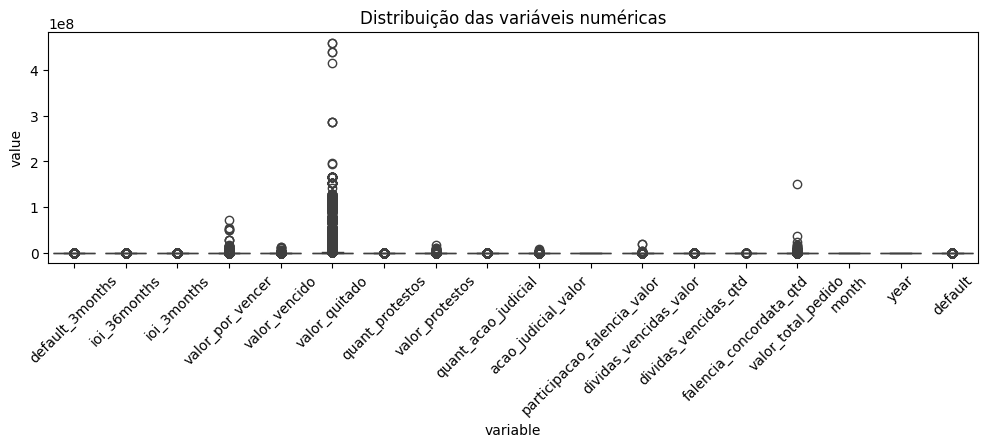

In [17]:
plt.figure(figsize = (12, 3))  # Define largura e altura da figura
df_longo = df.melt(value_vars = numeric_cols) # Converte o dataframe para formato longo para facilitar.
sns.boxplot(x = "variable", y = "value", data = df_longo)
plt.xticks(rotation = 45)
plt.title("Distribuição das variáveis numéricas")
plt.show()

### Histograma

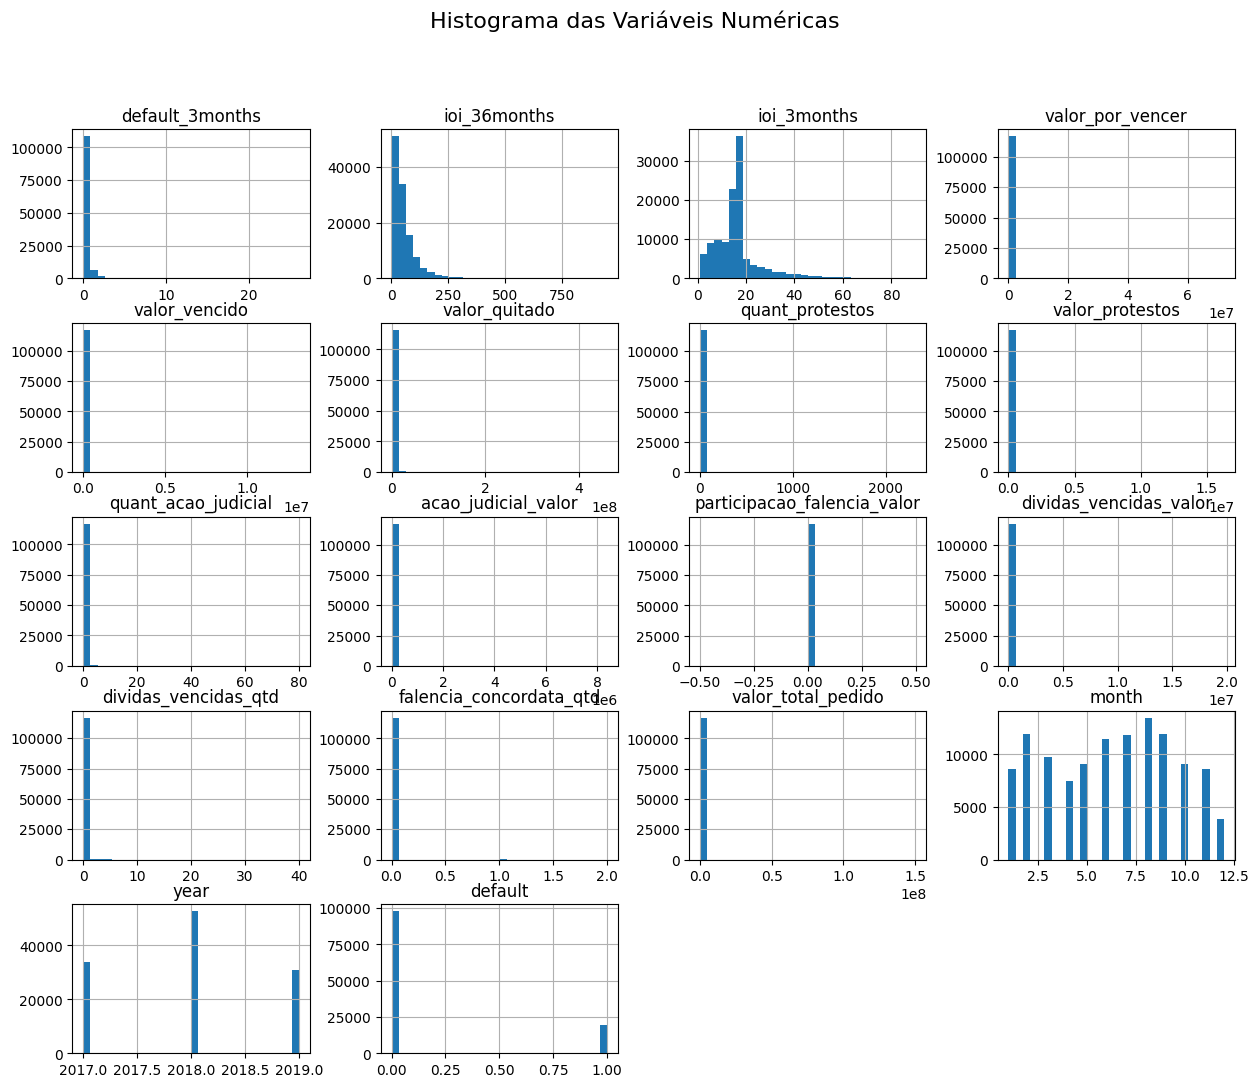

In [18]:
df[numeric_cols].hist(figsize=(15, 12), bins=30)
plt.suptitle("Histograma das Variáveis Numéricas", fontsize=16)
plt.show()


#### Atenção para tratamento

### Análise de Erros ou Características

valor_quitado

ioi_3months

valor_total_pedido

valor_por_vencer e valor_vencido tbm precisam de atenção

In [19]:
# Proporção de outliers por variável
outlier_proportion = outliers.sum() / len(df) * 100 #soma todos os outliers e divide pelo tamanho em %
print(outlier_proportion[outlier_proportion > 0].sort_values(ascending=False))

default                    16.666240
valor_quitado              14.239424
valor_por_vencer           14.007487
valor_total_pedido         12.939892
valor_vencido              10.594937
ioi_3months                 9.701295
default_3months             7.584013
ioi_36months                6.248668
valor_protestos             4.362470
quant_protestos             3.734022
quant_acao_judicial         0.824572
dividas_vencidas_valor      0.672789
dividas_vencidas_qtd        0.605425
acao_judicial_valor         0.471549
falencia_concordata_qtd     0.046046
dtype: float64


In [20]:
# Filtrar somente os outliers
outlier_data = df[numeric_cols][(df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)]

# Estatísticas descritivas dos outliers
print(outlier_data.describe())

       default_3months  ioi_36months   ioi_3months  valor_por_vencer  \
count      8894.000000   7328.000000  11377.000000      1.642700e+04   
mean          1.960985    231.218644     43.175587      4.114063e+05   
std           2.461430    105.815778     13.435311      1.352334e+06   
min           1.000000    144.167148     28.940777      4.931366e+04   
25%           1.000000    164.000000     33.000000      7.364279e+04   
50%           1.000000    193.000000     39.000000      1.178914e+05   
75%           2.000000    256.000000     49.000000      2.841472e+05   
max          26.000000    951.000000     90.000000      7.219759e+07   

       valor_vencido  valor_quitado  quant_protestos  valor_protestos  \
count   1.242500e+04   1.669900e+04      4379.000000     5.116000e+03   
mean    2.316241e+04   6.838345e+06         6.439598     4.701504e+04   
std     2.476860e+05   1.872137e+07        55.057814     4.203768e+05   
min     1.000000e-02   8.014977e+05         1.000000     6.

tratar especialmente as variaveis valor_quitado, valor_por_vencer e valor_total_pedido, contém extremos que precisam de atenção

variáveis "temporais" : default_3months, ioi_36months, ioi_3months contém outliers (nos máximos) consideravelmente acima dos 75% IQR

quant_protestos e quant_acao_judicial - possuem alguns outliers dado que os máximos são bem discrepantes com a distribuição

dividas_vencidas_valor também possui um máximo bem acima do 75% IQR

In [21]:
#verificando 'Valor total (em Reais) de falências apresentadas pelo Serasa' 
df.participacao_falencia_valor.sum()

np.float64(0.0)

- analisar por que participacao_falencia_valor está completamente zerada

##### clientes possivelmente problemáticos

In [22]:
print(df[['quant_protestos', 'quant_acao_judicial', 'default_3months']].quantile([0.50, 0.75, 0.90]))

      quant_protestos  quant_acao_judicial  default_3months
0.50              0.0                  0.0              0.0
0.75              0.0                  0.0              0.0
0.90              0.0                  0.0              0.0


In [23]:
# Filtrar clientes problemáticos
clientes_problemas = df[
    (df['quant_protestos'] > 0) |
    (df['quant_acao_judicial'] > 0) |
    (df['default_3months'] > 0)
]

# Exibir uma amostra dos clientes problemáticos
print(clientes_problemas[['quant_protestos', 'quant_acao_judicial', 'default_3months']].head())


    quant_protestos  quant_acao_judicial  default_3months
1                 0                    0                1
2                 1                    0                0
19                1                    0                0
26                1                    0                0
27                0                    0                2


In [24]:
print(clientes_problemas.shape[0])  # Número total de clientes problemáticos
percentual = (clientes_problemas.shape[0] / len(df)) * 100
print(f"Clientes problemáticos representam {percentual:.2f}% do total")

13321
Clientes problemáticos representam 11.36% do total


In [25]:
# Estatísticas descritivas dos clientes problemáticos
stats_problemas = clientes_problemas.describe()
print(stats_problemas)

       default_3months  ioi_36months   ioi_3months  valor_por_vencer  \
count     13321.000000  13321.000000  13321.000000      1.332100e+04   
mean          1.309286     35.536025     14.909150      2.728233e+05   
std           2.213217     43.524879     11.794143      1.442506e+06   
min           0.000000      1.000000      1.000000      0.000000e+00   
25%           0.000000     11.568966      7.000000      6.122630e+03   
50%           1.000000     23.000000     13.206575      2.193864e+04   
75%           1.000000     43.450140     18.207250      8.848184e+04   
max          26.000000    775.000000     89.000000      7.219759e+07   

       valor_vencido  valor_quitado  quant_protestos  valor_protestos  \
count   1.332100e+04   1.332100e+04     13321.000000     1.332100e+04   
mean    1.704490e+04   4.983120e+06         2.116883     1.803107e+04   
std     2.378228e+05   2.019066e+07        31.709553     2.615044e+05   
min     0.000000e+00   0.000000e+00         0.000000     0.

In [26]:
# quantidade de clientes em cada tipo de situação problema
print(clientes_problemas[['quant_protestos', 'quant_acao_judicial', 'default_3months']].sum())

quant_protestos        28199
quant_acao_judicial     2219
default_3months        17441
dtype: int64


In [27]:
clientes_multiplos = clientes_problemas[
    (clientes_problemas['quant_protestos'] > 0) & 
    (clientes_problemas['quant_acao_judicial'] > 0) & 
    (clientes_problemas['default_3months'] > 0)
]
print(f"Clientes com múltiplos problemas: {clientes_multiplos.shape[0]}")

percentual = (clientes_multiplos.shape[0] / len(df)) * 100
print(f"Clientes com mais de um representam {percentual:.2f}% do total")

Clientes com múltiplos problemas: 83
Clientes com mais de um representam 0.07% do total


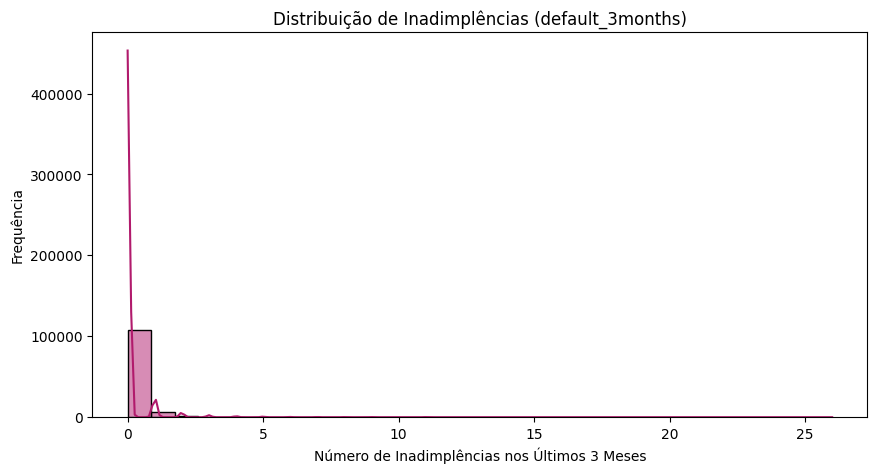

In [28]:
"""Plota a distribuição de inadimplências (default_3months)."""
plt.figure(figsize=(10, 5))
sns.histplot(df['default_3months'], bins=30, kde=True, color=COR_1)
plt.title("Distribuição de Inadimplências (default_3months)")
plt.xlabel("Número de Inadimplências nos Últimos 3 Meses")
plt.ylabel("Frequência")
plt.show()

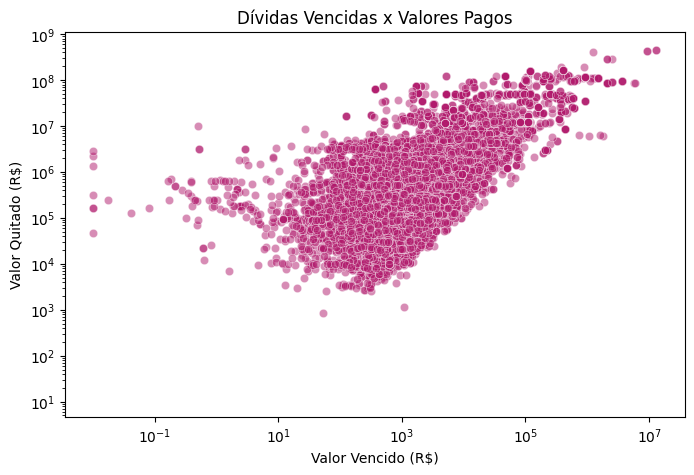

In [29]:
"""Plota um gráfico de dispersão entre dívidas vencidas e valores quitados."""
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['valor_vencido'], y=df['valor_quitado'], alpha=0.5, color=COR_1)
plt.title("Dívidas Vencidas x Valores Pagos")
plt.xlabel("Valor Vencido (R$)")
plt.ylabel("Valor Quitado (R$)")
plt.xscale("log")
plt.yscale("log")
plt.show()

clientes com valores em debito altos também possuem altos valores de pagamento, mas existem outliers

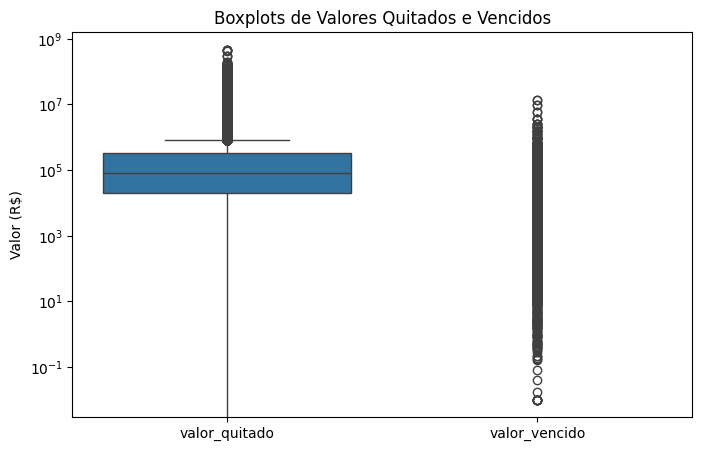

In [30]:
"""Plota boxplots para entender os valores extremos."""
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['valor_quitado', 'valor_vencido']])
plt.title("Boxplots de Valores Quitados e Vencidos")
plt.ylabel("Valor (R$)")
plt.yscale("log")
plt.show()

#### Valores muito altos

In [31]:
# Definir os limites para valores altos
corte = 0.95


corte_valor_quitado = df['valor_quitado'].quantile(corte)
corte_valor_vencido = df['valor_vencido'].quantile(corte)
corte_quant_protestos = df['quant_protestos'].quantile(corte)
corte_quant_acao_judicial = df['quant_acao_judicial'].quantile(corte)

# Filtrar os clientes com valores extremamente altos
clientes_extremos = df[
    (df['valor_quitado'] >= corte_valor_quitado) |
    (df['valor_vencido'] >= corte_valor_vencido) |
    (df['quant_protestos'] >= corte_quant_protestos) |
    (df['quant_acao_judicial'] >= corte_quant_acao_judicial)
]

# Exibir uma amostra dos clientes filtrados
print(clientes_extremos[['valor_quitado', 'valor_vencido', 'quant_protestos', 'quant_acao_judicial']].head())


   valor_quitado  valor_vencido  quant_protestos  quant_acao_judicial
0      242100.70            0.0                0                    0
1     4960846.21            0.0                0                    0
2      158631.93            0.0                1                    0
3      669644.16            0.0                0                    0
4        2010.56            0.0                0                    0


In [32]:
# descritiva dos clientes extremos
print(clientes_extremos.describe())

       default_3months   ioi_36months    ioi_3months  valor_por_vencer  \
count    117273.000000  117273.000000  117273.000000      1.172730e+05   
mean          0.148721      55.582906      17.106291      6.421384e+04   
std           0.853794      60.989240      10.993605      5.252546e+05   
min           0.000000       1.000000       1.000000      0.000000e+00   
25%           0.000000      20.166667      11.121543      5.657400e+02   
50%           0.000000      38.000000      16.000000      4.451740e+03   
75%           0.000000      69.750000      18.248850      2.006296e+04   
max          26.000000     951.000000      90.000000      7.219759e+07   

       valor_vencido  valor_quitado  quant_protestos  valor_protestos  \
count   1.172730e+05   1.172730e+05    117273.000000     1.172730e+05   
mean    2.454043e+03   1.085557e+06         0.240456     2.051017e+03   
std     8.093313e+04   7.444825e+06        10.707825     8.831758e+04   
min     0.000000e+00   0.000000e+00      

In [33]:
# total de clientes por situação
print(clientes_extremos[['valor_quitado', 'valor_vencido', 'quant_protestos', 'quant_acao_judicial']].gt(0).sum())

valor_quitado          112613
valor_vencido           12425
quant_protestos          4379
quant_acao_judicial       967
dtype: int64


In [34]:
#Características adicionais dos clientes extremos

# Agrupar por setor de atividade principal
atividade_principal_extremos = clientes_extremos.groupby('atividade_principal').size().sort_values(ascending=False)
print("Distribuição por Atividade Principal:")
print(atividade_principal_extremos)

# Agrupar por tipo de sociedade
tipo_sociedade_extremos = clientes_extremos.groupby('tipo_sociedade').size().sort_values(ascending=False)
print("\nDistribuição por Tipo de Sociedade:")
print(tipo_sociedade_extremos)


Distribuição por Atividade Principal:
atividade_principal
com de equipamentos de informatica              22629
com de telefones e equip p/ comunicacoes         9851
papelaria                                        9075
com de moveis e estofados                        8226
com de eletrodomesticos                          8156
                                                ...  
locacao de roupas e outros art do vestuario         2
revendedora honda                                   2
promocao de eventos                                 2
sindicato de empregados                             2
usinagem, tratamento, revestimento de metais        1
Length: 203, dtype: int64

Distribuição por Tipo de Sociedade:
tipo_sociedade
sociedade empresaria limitada                     60020
empresario (individual)                           27055
empresa individual respons limitada empresaria    19201
empresario-mei(microempreendedor individual)       6886
sociedade anonima fechada                     

### Segmentação de risco

In [35]:
# DF para armazenar a segmentação de risco
segmentacao_risco = df.groupby(['atividade_principal', 'tipo_sociedade']).agg(
    taxa_inadimplencia=('default', 'mean'),
    total_clientes=('default', 'count'),
)

# Ordenar pela maior taxa de inadimplência
segmentacao_risco = segmentacao_risco.sort_values(by='taxa_inadimplencia', ascending=False)

# Exibir os segmentos com maior inadimplência
print(segmentacao_risco['taxa_inadimplencia'].head(20))

atividade_principal                          tipo_sociedade                                
tv por assinatura                            empresario (individual)                           1.0
transporte rodoviario de passageiros         sociedade empresaria limitada                     1.0
agencia de viagem e turismo                  empresario (individual)                           1.0
                                             sociedade empresaria limitada                     1.0
servicos de softwares                        empresario-mei(microempreendedor individual)      1.0
servicos de telecomunicacoes                 empresa individual respons limitada empresaria    1.0
com atacad-papeis e embalagens descartaveis  empresario (individual)                           1.0
com  de gas liquefeito de petroleo           sociedade empresaria limitada                     1.0
servicos                                     sociedade anonima fechada                         1.0
serv de selecao e

muitos MEI com problema de inadimplência

## Análise de Correlação

In [36]:
df_correlacao = df.copy()

In [37]:
FEATURES_NUMERICAS = df.select_dtypes(include=['number']).columns.tolist()
FEATURES_CATEGORICAS = df.select_dtypes(exclude=['number']).columns.tolist()
TODAS_FEATURES = FEATURES_NUMERICAS + FEATURES_CATEGORICAS

In [38]:
df_correlacao.columns.values

array(['default_3months', 'ioi_36months', 'ioi_3months',
       'valor_por_vencer', 'valor_vencido', 'valor_quitado',
       'quant_protestos', 'valor_protestos', 'quant_acao_judicial',
       'acao_judicial_valor', 'participacao_falencia_valor',
       'dividas_vencidas_valor', 'dividas_vencidas_qtd',
       'falencia_concordata_qtd', 'tipo_sociedade', 'opcao_tributaria',
       'atividade_principal', 'forma_pagamento', 'valor_total_pedido',
       'month', 'year', 'default'], dtype=object)

In [39]:
# análise de campos em branco
df_correlacao[TODAS_FEATURES].isna().sum().sort_values(ascending=False)

forma_pagamento                32477
opcao_tributaria               18325
tipo_sociedade                   608
atividade_principal              592
default_3months                    0
ioi_36months                       0
valor_quitado                      0
valor_vencido                      0
valor_por_vencer                   0
ioi_3months                        0
quant_protestos                    0
valor_protestos                    0
quant_acao_judicial                0
acao_judicial_valor                0
falencia_concordata_qtd            0
dividas_vencidas_qtd               0
dividas_vencidas_valor             0
participacao_falencia_valor        0
default                            0
year                               0
month                              0
valor_total_pedido                 0
dtype: int64

In [40]:
#preenchendo valores vazios sem viés 
df_correlacao['forma_pagamento'].fillna("Desconhecido", inplace=True)
df_correlacao['opcao_tributaria'].fillna("Desconhecido", inplace=True)
df_correlacao['tipo_sociedade'].fillna("Desconhecido", inplace=True)
df_correlacao['atividade_principal'].fillna("Desconhecido", inplace=True)

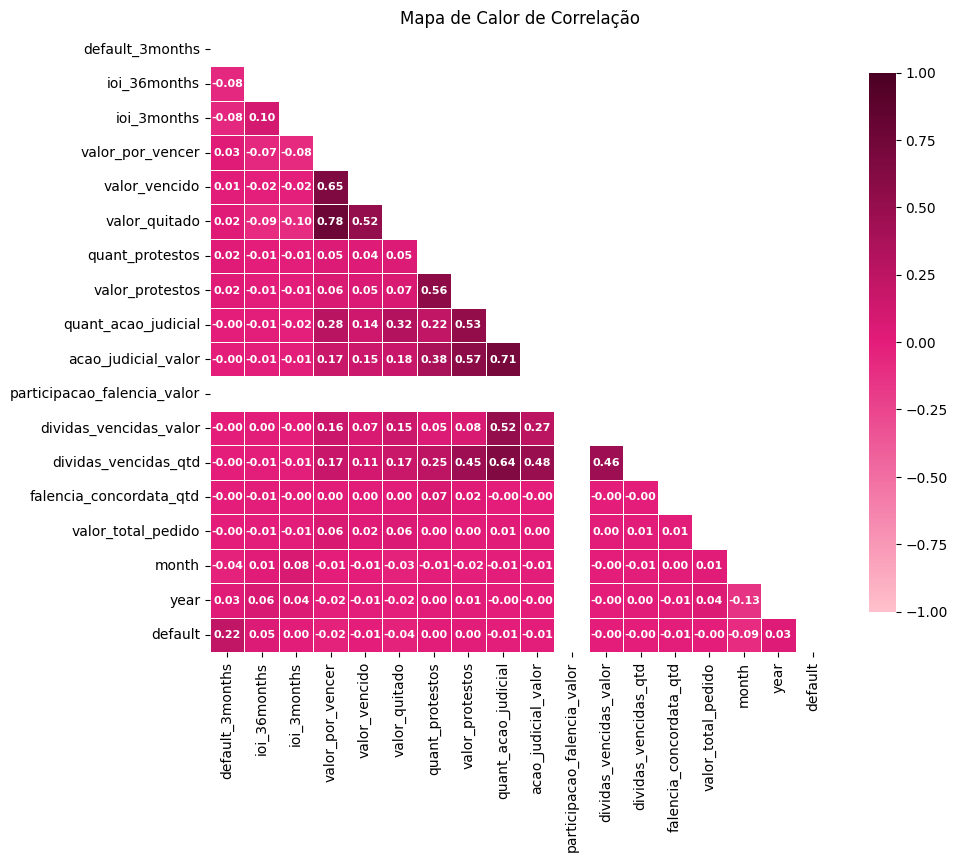

In [41]:
cores = ["#FFC0CB", "#e31c79", "#4B0023"]
correlation_heatmap(df_correlacao, cores=cores)

### WoE / IV

In [42]:
from x_health.utils import *
#calculando iv e woe
iv, woe = iv_woe(data = df_correlacao, target='default', bins=10, show_woe=False,show_iv=False)

#### WoE (Peso da Evidência)
- positivo: Indica que essa categoria tem uma maior proporção de eventos (default) do que de não eventos (pagamento em dia).
- negativo: Indica que essa categoria tem menos inadimplentes proporcionalmente.
- próximo de zero: A categoria tem uma distribuição equilibrada entre eventos e não eventos.

In [43]:
woe.sort_values(by="WoE", ascending=False).head(10)

,Variavel,Corte,N,Eventos,% de Eventos,Nao-Eventos,% de Nao-Eventos,WoE,IV
171,atividade_principal,serv de selecao e administracao de pessoal,20,15,0.000767,5,0.000051,2.708081,0.001940
166,atividade_principal,reparacao de joias e relogios,25,18,0.000921,7,0.000072,2.553930,0.002169
121,atividade_principal,ind de especiarias e condimentos,13,9,0.000460,4,0.000041,2.420399,0.001015
15,tipo_sociedade,sociedade simples limitada,121,77,0.003940,44,0.000450,2.169084,0.007569
9,forma_pagamento,105/135/165,19,12,0.000614,7,0.000072,2.148465,0.001165
12,atividade_principal,com de gas liquefeito de petroleo,16,10,0.000512,6,0.000061,2.120294,0.000955
76,forma_pagamento,"60,12,30",45,27,0.001381,18,0.000184,2.014934,0.002412
38,forma_pagamento,28/42/56/70/84/98/112,134,78,0.003991,56,0.000573,1.940826,0.006633
8,forma_pagamento,105/120/135,45,26,0.001330,19,0.000194,1.923126,0.002184
66,atividade_principal,com importacao e exportacao de produtos,11,6,0.000307,5,0.000051,1.791790,0.000458


#### IV
O cálculo de do IV é dado por

    | IV =   ∑ (% of non-events - % of events) * WOE

a interpretação do valor é dada pelo nível de relacionamento com Razão de Probabilidades da variável em questão e a variável resposta:

- \>= 0.02 : variável pode não ser útil na modelagem
- 0,02 < IV > = 0.1 : fraco
- 0.1 < IV >= 0.3 : médio
- 0.3 < IV >= 0.5 : forte
- \> 0.5 : informação suspeita, boa demais para ser real. Verificar com mais detalhes

In [44]:
print('Variáveis com IV <= 0.02 devem ser descartadas')
display(iv.sort_values(by=['IV'], ascending=False).query("IV <= 0.02"))

Variáveis com IV <= 0.02 devem ser descartadas


,Variavel,IV
0,valor_por_vencer,0.009664
0,falencia_concordata_qtd,0.001220
0,default_3months,0.000000
0,dividas_vencidas_qtd,0.000000
0,participacao_falencia_valor,0.000000
0,dividas_vencidas_valor,0.000000
0,quant_acao_judicial,0.000000
0,valor_protestos,0.000000
0,quant_protestos,0.000000
0,acao_judicial_valor,0.000000


In [45]:
print('Variáveis com IV > 0.02')
display(iv.sort_values(by=['IV'], ascending=False).query("IV > 0.02"))

Variáveis com IV > 0.02


,Variavel,IV
0,forma_pagamento,0.467591
0,atividade_principal,0.280345
0,opcao_tributaria,0.191230
0,month,0.143443
0,valor_vencido,0.098016
0,ioi_3months,0.095854
0,ioi_36months,0.069786
0,tipo_sociedade,0.065181
0,valor_total_pedido,0.063829
0,valor_quitado,0.033826


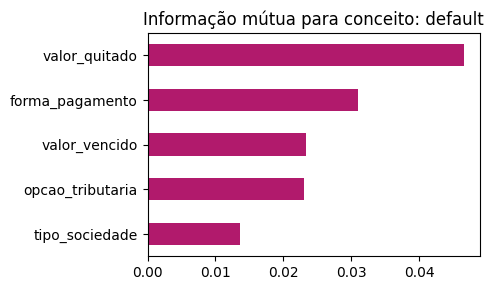

In [46]:
from x_health.plots import plot_mi
# Criando uma cópia do DataFrame original
df_encoded = df_correlacao.copy()

# Lista de variáveis categóricas
categorical_features = ['forma_pagamento', 'opcao_tributaria', 'tipo_sociedade']

# Aplicando Label Encoding
for col in categorical_features:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Lista de variáveis preditoras
features = ['forma_pagamento', 'opcao_tributaria', 'tipo_sociedade', 'valor_vencido', 'valor_quitado']

# Chamando a função de plot
plot_mi(database=df_encoded, features=features, target_variable=inadimplencia, n=10, figsize=(5, 3))

forma_pagamento, opcao_tributaria, tipo_sociedade são potencialmente preditivas

analisar  atividade_principal pelo WoE em algumas categorias

### Agrupando variáveis forma_pagamento, opcao_tributaria, tipo_sociedade
##### forma_pagamento

In [47]:
variavel_analise = 'forma_pagamento'
var_analise_agrup = f'{variavel_analise}_agrup'
#idenfificando o formato descrito em forma_pagamento para agrupar as categorias internas
df['forma_pagamento'].unique()

array(['30/60/90', <NA>, '28 dias', '30/45', '60/90/120', '30/60/90/120',
       '30 dias', '35/49/63/77/91', '120', '28/56/84', '28/42/56',
       '28/35/42 dd', '30/60', '60/90/120/150/180/210', '42/49/56/63/70',
       '21/28/35/42/49/56/63', '120/150/180', '30/60/90/120/150',
       '42 dias', '21/29/35 dd', '21/28/35/42/49', 'boleto 7 dias',
       '49/56/63', '30/45/60', '14/28/42', '14', '28/42/56/70/84/98/112',
       '28/56', '55/62/69/76/83/90/97', '10/40/70', '28/42 dd',
       '40,70,100,130', '28/42/56/70/84', '60 dias', '21',
       '28/35/42/49/56', '35/42/49/56/63', '42/49/56', '90/120/150',
       'boleto14/21/28/35/42', '10', '30/45/60/75/90', '35/42/49',
       '12 vezes, 1a, 30dd', '10x,1a. 30dd', '14/28/42/56/70', '140 dias',
       '14/28', '30/45/60/75/90/105/120', '60/90', '27/34/41/48/55/62/69',
       '56 dias', '80 dias', '42/56/70', 'boleto 14 dias', '75',
       'boleto 28 dias', '20/40/60/80/100', '35 dd', '35/49',
       '30/60/90/120/150/180/210/240/270/

In [48]:
len(df_correlacao[variavel_analise].unique())

105

In [49]:
from x_health.utils import agrupar_prazo
#agrupar por tipo de pagamento pode trazer benefícios
df_correlacao[var_analise_agrup] = agrupar_prazo(df_correlacao, variavel_analise)
print(df_correlacao[var_analise_agrup].value_counts())

forma_pagamento_agrup
Médio prazo (31-90 dias)    63957
Outros                      44101
Curto prazo (16-30 dias)     4210
Longo prazo (+90 dias)       2577
À vista (até 15 dias)        2427
Sem pagamento                   1
Name: count, dtype: int64


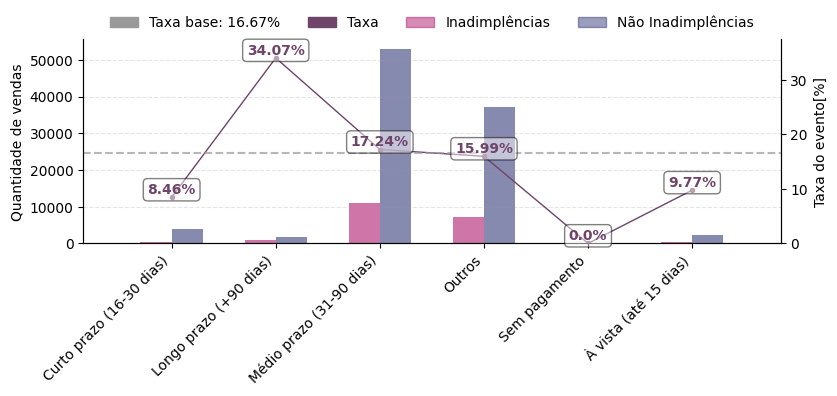

In [50]:
from x_health.plots import plot_distribuicao_bivariada
plot_distribuicao_bivariada(df=df_correlacao, variavel_analise=var_analise_agrup, nom_variavel_conceito=inadimplencia, taxa_evento=taxa_inadimplencia, figsize=(9,3))

apesar da maior taxa ser a longo prazo, o volume maior se encontra em médio prazo
- clientes que optam por longo prazo podem ter maior incerteza financeira ou perfil de risco maior
- pagamentos a vista indicam melhor capacidade de pagamento e disciplina financeira
- 'sem pagamento' pode conter erro na categorização dos dados
- em outras formas de pagamento podem existir condições mais específicas de pagamentos que não foram classificadas corretamente

##### tipo_sociedade

In [51]:
variavel_analise = 'tipo_sociedade'
var_analise_agrup = f'{variavel_analise}_agrup'
df_correlacao[variavel_analise].unique()

array(['empresario (individual)', 'sociedade empresaria limitada',
       'empresa individual respons limitada empresaria',
       'empresario-mei(microempreendedor individual)',
       'sociedade anonima fechada', 'Desconhecido', 'cooperativa',
       'sociedade de economia mista', 'fundacao privada',
       'outras formas de associacao', 'sociedade anonima aberta',
       'sociedade simples pura', 'sociedade simples limitada',
       'organizacao religiosa', 'servico social autonomo', 'municipio',
       'entidade sindical'], dtype=object)

In [52]:
# Aplicar no DataFrame
df_correlacao[var_analise_agrup] = agrupar_tipo_sociedade(df, variavel_analise)

# Exibir as contagens
print(df_correlacao[var_analise_agrup].value_counts())

tipo_sociedade_agrup
Sociedade Limitada                   79342
Empresa Individual                   33941
Sociedade Anônima                     2562
Cooperativas & Associações             675
Desconhecido                           608
Organizações Públicas & Fundações      116
Outros                                  29
Name: count, dtype: int64


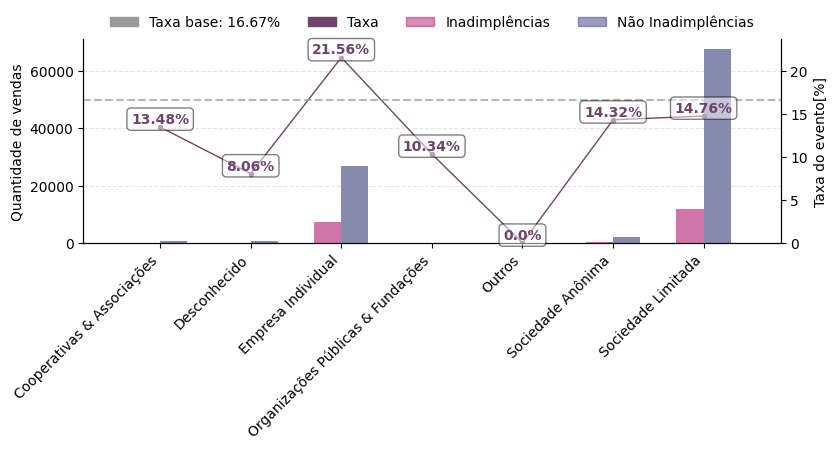

In [53]:
plot_distribuicao_bivariada(df=df_correlacao, variavel_analise=var_analise_agrup, nom_variavel_conceito=inadimplencia, taxa_evento=taxa_inadimplencia, figsize=(9,3))

empresas individuais possuem a maior taxa, embora o maior volume seja para sociedade limitada
- empresas individuais podem ser mais voláteis financeiramente, causando um risco maior
- organizações publicas provavelmente possuem fonte de renda mais estável
- LTDA são o tipo mais comum no mercado, com médio risco
- cooperativas e associações possuem pouca participação nesta empresa, pela sua natureza
- classificação de outros irrelevante para causar alguma distorção na modelagem

##### atividade_principal

In [54]:
variavel_analise = 'atividade_principal'
var_analise_agrup = f'{variavel_analise}_agrup'
# Exibir as contagens
print(df_correlacao[variavel_analise].value_counts()) 

atividade_principal
com de equipamentos de informatica              22629
com de telefones e equip p/ comunicacoes         9851
papelaria                                        9075
com de moveis e estofados                        8226
com de eletrodomesticos                          8156
                                                ...  
sindicato de empregados                             2
bco mult priv nacional c/ partic estrangeira        2
promocao de eventos                                 2
emissora de radio                                   2
usinagem, tratamento, revestimento de metais        1
Name: count, Length: 204, dtype: int64


In [55]:
#avalia quais as TOP 10 atividades com maior taxa de inadimplencia 
top_activities = segmentacao_risco.groupby('atividade_principal')['taxa_inadimplencia'].mean().sort_values(ascending=False).head(10)
top_activities

atividade_principal
serv de selecao e administracao de pessoal     0.852941
ind de especiarias e condimentos               0.833333
cooperativa de producao                        0.829808
reparacao de joias e relogios                  0.781250
ind de brinquedos                              0.777778
com  de gas liquefeito de petroleo             0.769231
entidades sem fins lucrativos                  0.717949
servicos de radiocomunicacao e telemensagem    0.704545
transporte rodoviario de passageiros           0.642857
ind de cabos, fios e condutores eletricos      0.600000
Name: taxa_inadimplencia, dtype: float64

In [56]:
# Agrupar por atividade principal no DataFrame
df_correlacao[var_analise_agrup] = agrupar_atividade_principal(df, variavel_analise)

# Exibir as contagens
print(df_correlacao[var_analise_agrup].value_counts())

atividade_principal_agrup
Comércio            76743
Outros              38013
Indústria            1278
Desconhecido          592
Educação              497
Serviços              103
OSC                    23
RH                     20
Construção Civil        4
Name: count, dtype: int64


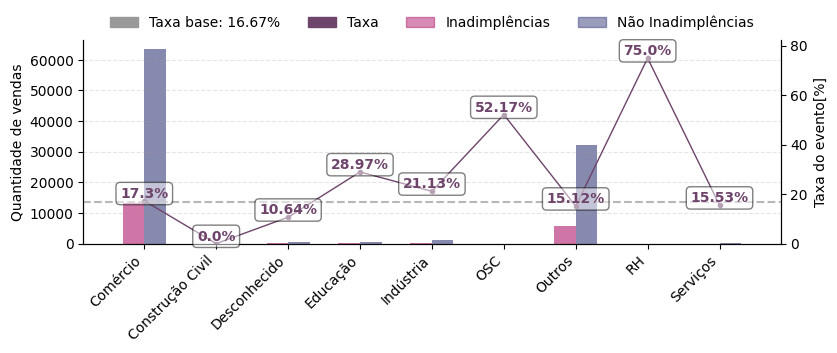

In [57]:
plot_distribuicao_bivariada(df=df_correlacao, variavel_analise=var_analise_agrup, nom_variavel_conceito=inadimplencia, taxa_evento=taxa_inadimplencia, figsize=(9,3))

embora existam taxas mais altas em outras atividades, a atividade de comércio abrange um numero muito grande de registros, com uma taxa levemente acima da taxa base
###### Análise sobre Comercio

In [58]:
# Filtrar os valores da coluna 'atividade_principal' que começam com "com de"
df_correlacao_filtrado = df_correlacao[df_correlacao['atividade_principal'].str.startswith("com de", na=False)]

# Exibir os resultados
print(df_correlacao_filtrado['atividade_principal'].unique())

['com de equipamentos de informatica'
 'com de compon eletron e pecas para eletrod'
 'com de livros, revistas e jornais' 'com de moveis e estofados'
 'com de brinquedos' 'com de confeccoes em geral'
 'com de telefones e equip p/ comunicacoes' 'com de eletrodomesticos'
 'com de auto pecas e acessorios'
 'com de motocicletas, pecas e acessorios'
 'com de instrumentos e materiais para uso med'
 'com de tratores e implementos agricolas' 'com de artigos ortopedicos'
 'com de maquinas e equip para escritorio' 'com de bebidas'
 'com de material para construcao' 'com de ferramentas e ferragens'
 'com de produtos e material eletrico'
 'com de prod- cine, foto, som, instr musicais'
 'com de produtos alimenticios e bebidas' 'com de artigos de otica'
 'com de produtos esportivos e recreativos'
 'com de artigos pirotecnicos e explosivos'
 'com de prod- higiene, perfumaria, cosmeticos'
 'com de maquinas, equipamentos  e pecas' 'com de produtos odontologicos'
 'com de bicicletas, ciclomot, pecas e ac

In [59]:
# Agrupar por tipo de comércio no DataFrame
df_correlacao_filtrado['tipo_comercio_agrup'] = agrupar_tipo_comercio(df, variavel_analise)

# Exibir as contagens
print(df_correlacao_filtrado['tipo_comercio_agrup'].value_counts())

tipo_comercio_agrup
Tecnologia & Eletrônicos    34518
Outros                      12196
Móveis & Decoração           8264
Moda & Vestuário             7272
Esportes & Lazer             7077
Automotivo                   3693
Construção & Ferragens       2137
Livros & Papelaria            755
Saúde & Ortopedia             679
Alimentação & Bebidas         152
Name: count, dtype: int64


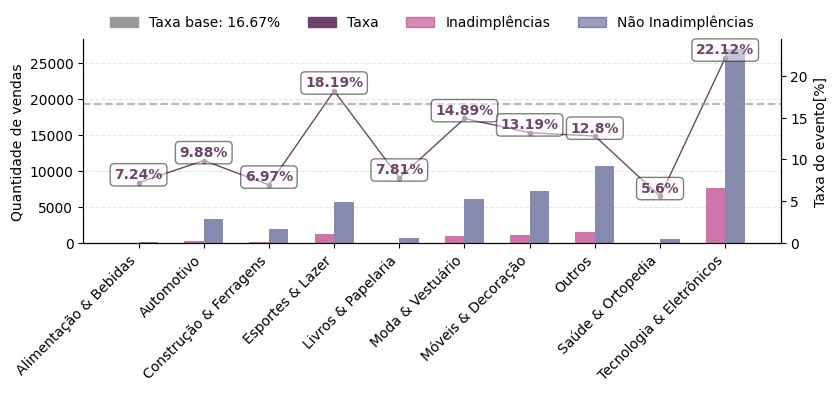

In [60]:
plot_distribuicao_bivariada(df=df_correlacao_filtrado, variavel_analise='tipo_comercio_agrup', nom_variavel_conceito=inadimplencia, taxa_evento=taxa_inadimplencia, figsize=(9,3))

observa-se um aumento consideravel no volume e na taxa quando se trata de comercio de tecnologia & eletronicos. Esporte & Lazer também apresenta uma taxa acima da taxa base

##### opcao_tributaria

In [61]:
variavel_analise = 'opcao_tributaria'
var_analise_agrup = f'{variavel_analise}_agrup'
# Exibir as contagens
print(df_correlacao[variavel_analise].value_counts())

opcao_tributaria
simples nacional    87993
Desconhecido        18325
lucro real           7807
lucro presumido      2757
isento                391
Name: count, dtype: int64


In [62]:
# Aplicar no DataFrame
df_correlacao[var_analise_agrup] = agrupar_opcao_tributaria(df, variavel_analise)

# Exibir as contagens
print(df_correlacao[var_analise_agrup].value_counts())

opcao_tributaria_agrup
Simples Nacional    87993
Desconhecido        18325
Lucro Real           7807
Lucro Presumido      2757
Outros                391
Name: count, dtype: int64


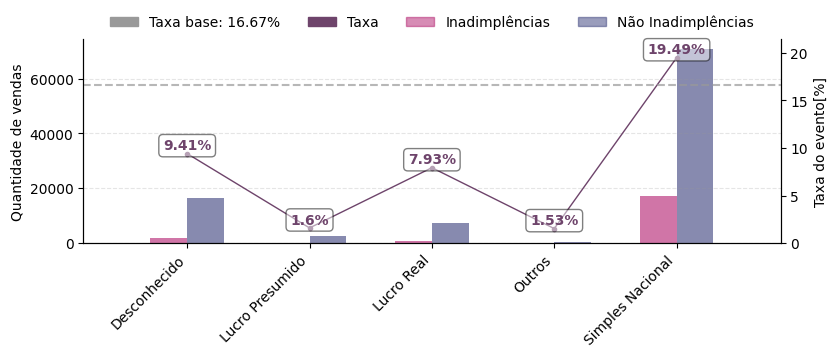

In [63]:
plot_distribuicao_bivariada(df=df_correlacao, variavel_analise=var_analise_agrup, nom_variavel_conceito=inadimplencia, taxa_evento=taxa_inadimplencia, figsize=(9,3))

optantes pelo simples nacional são maioria e com a maior taxa de inadimplencia, podendo indicar que pequenos negócios tenham maior propensão a serem inadiplentes

#### Qui-Quadrado (Chi-Square Test of Independence)
- Avalia se há relação entre duas categóricas
- teste principalmente para forma_pagamento, opcao_tributaria e tipo_sociedade

In [64]:
var_alvo = 'forma_pagamento'
tabela_contingencia = pd.crosstab(df_correlacao[var_alvo], df_correlacao['default'])
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Valor do Qui-Quadrado para {var_alvo}: {chi2}, p-valor: {p}")

Valor do Qui-Quadrado para forma_pagamento: 5878.780792313853, p-valor: 0.0


In [65]:
# Lista de variáveis categóricas
categorical_vars = ['forma_pagamento', 'tipo_sociedade', 'atividade_principal', 'opcao_tributaria', 
                    'forma_pagamento_agrup','tipo_sociedade_agrup', 'atividade_principal_agrup', 'opcao_tributaria_agrup']

# Criar tabela com os valores de Qui-Quadrado e p-valor
chi2_results = []
for var in categorical_vars:
    contingency_table = pd.crosstab(df_correlacao[var], df_correlacao['default'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append({'Variável': var, 'Qui-Quadrado': chi2, 'p-Valor': p})

# Criar DataFrame com os resultados
chi2_df = pd.DataFrame(chi2_results)


# Exibir a tabela
print("Tabela de Qui-Quadrado")
print(chi2_df)


Tabela de Qui-Quadrado
                    Variável  Qui-Quadrado        p-Valor
0            forma_pagamento   5878.780792   0.000000e+00
1             tipo_sociedade   1128.914013  2.653580e-230
2        atividade_principal   4144.674749   0.000000e+00
3           opcao_tributaria   2144.162410   0.000000e+00
4      forma_pagamento_agrup    879.291532  8.068055e-188
5       tipo_sociedade_agrup    850.477852  1.902653e-180
6  atividade_principal_agrup    246.650318   8.834347e-49
7     opcao_tributaria_agrup   2144.162410   0.000000e+00


## Análise de sazonalidade
a sazonalidade pode explicar o comportamento de inadimplência

### Ano
Avaliando se há alterações relevantes nas taxas nos anos descritos

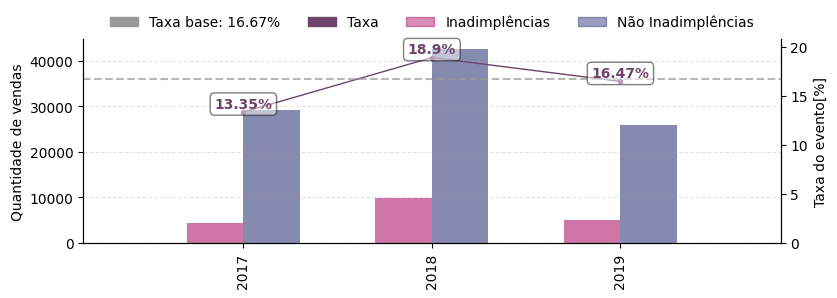

In [66]:
variavel_analise = 'year'
plot_distribuicao_bivariada(df, variavel_analise, 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True, figsize=(9,3))

### Mês
avaliando se há relação com o mês e a inadimplência

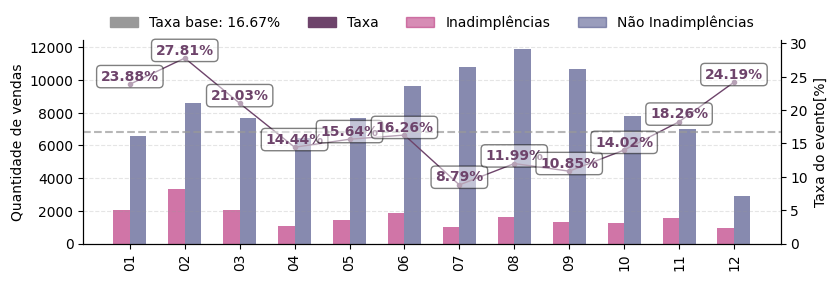

In [67]:
variavel_analise = 'month'
df[variavel_analise] = df[variavel_analise].astype(str).str.zfill(2)
plot_distribuicao_bivariada(df, variavel_analise, 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True, figsize=(9,3))

In [68]:
#Cria separação por trimestres
df["periodo_fiscal"] = df["month"].apply(lambda x: "1T" if x in ['01', '02', '03'] else 
                                         "2T" if x in ['04', '05', '06'] else 
                                         "3T" if x in ['07', '08', '09'] else "4T")

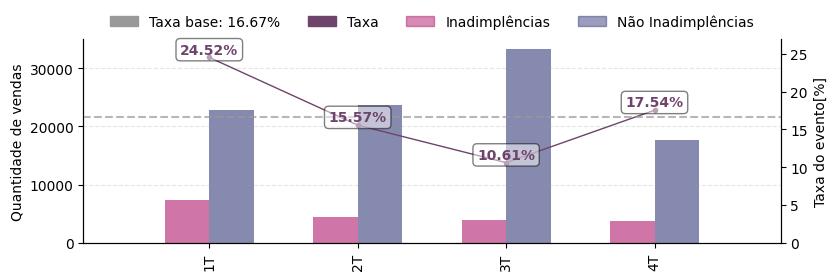

In [69]:
variavel_analise = 'periodo_fiscal'
df[variavel_analise] = df[variavel_analise].astype(str).str.zfill(2)
plot_distribuicao_bivariada(df, variavel_analise, 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True, figsize=(9,3))

o primeiro trimestre e o ultimo possuem as maiores taxas, embora o maior volume de vendas fique no terceiro trimestre
- pode indicar propensão a inadimplência após os gastos de fim de ano (13o, ferias etc)
- há algum tipo de promoção feita no 3o trimestre para o aumento de vendas?

### AnoMes

In [70]:
# Criar a variável 'Anomes'  MMYYYY tipo str
df['anomes'] = (df['month'].astype(str).str.zfill(2) + df['year'].astype(str)).astype(str)

# Exibir as primeiras linhas para conferir
df[['month', 'year', 'anomes']].head()

,month,year,anomes
0,06,2019,062019
1,10,2018,102018
2,04,2018,042018
3,04,2017,042017
4,10,2017,102017


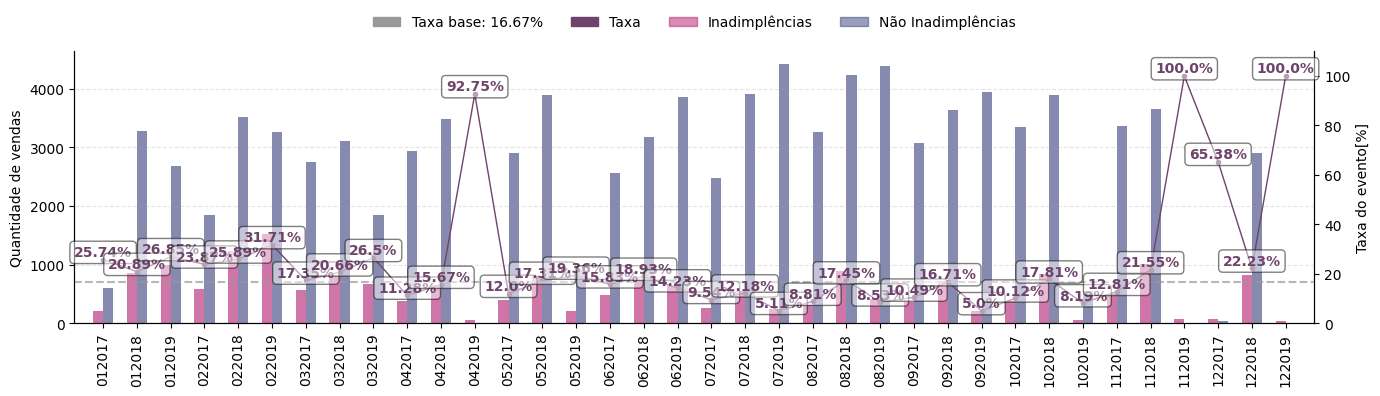

In [71]:
variavel_analise = 'anomes'
plot_distribuicao_bivariada(df, variavel_analise, 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True)

## Outras análises

In [72]:
### criar flag
df["flag_valor_vencido"] = (df["valor_vencido"] > 0).astype(int)

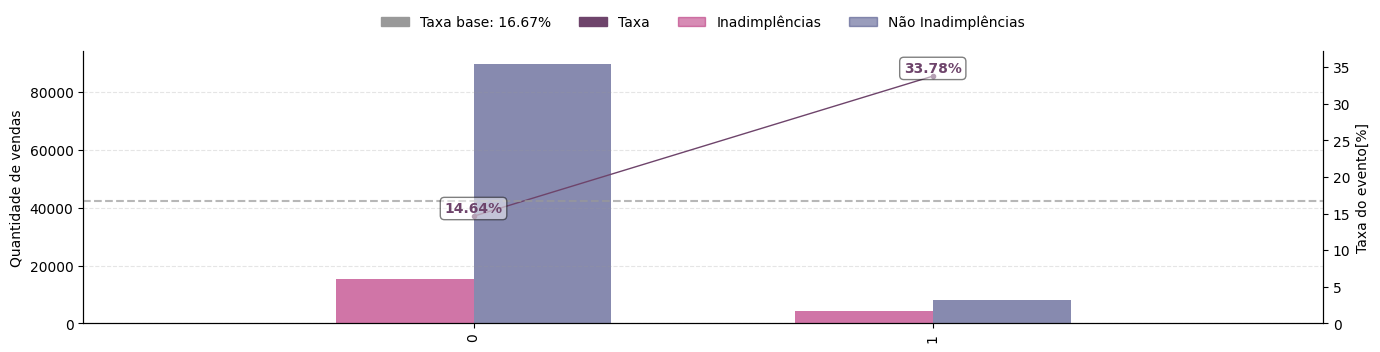

In [73]:
plot_distribuicao_bivariada(df, 'flag_valor_vencido', 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True)

In [74]:
## criar agrupamento da forma de pagamento
df['forma_pagamento_agrup'] = agrupar_prazo(df, 'forma_pagamento')

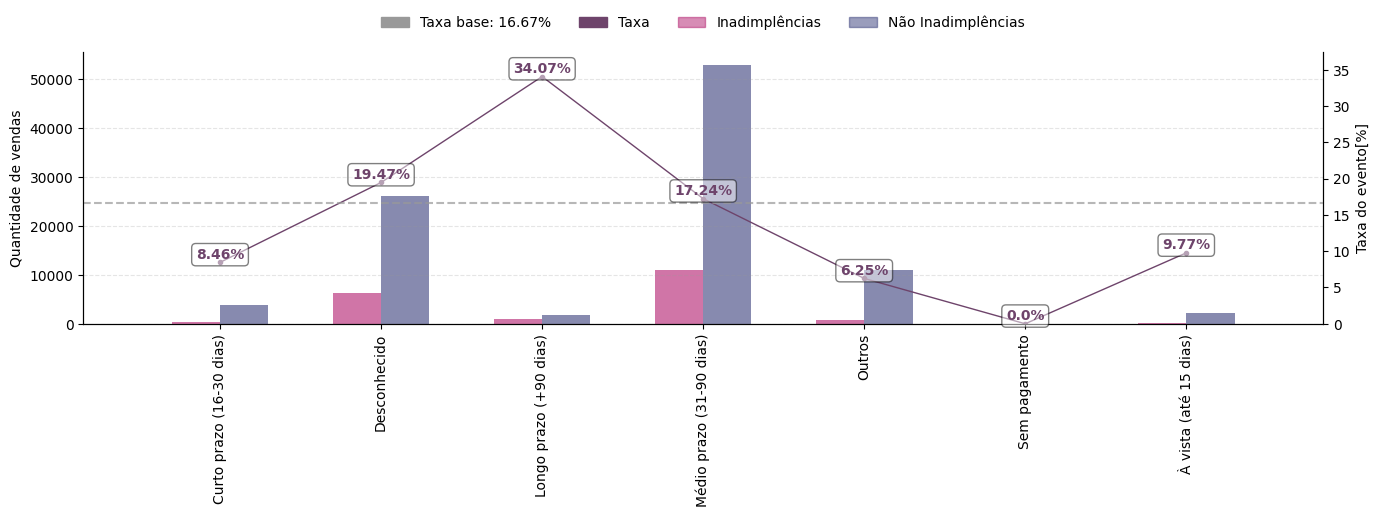

In [75]:
plot_distribuicao_bivariada(df, 'forma_pagamento_agrup', 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True)

In [76]:
#Cria separação por trimestres
df["periodo_fiscal"] = df["month"].apply(lambda x: "1T" if x in ['01', '02', '03'] else 
                                         "2T" if x in ['04', '05', '06'] else 
                                         "3T" if x in ['07', '08', '09'] else "4T")

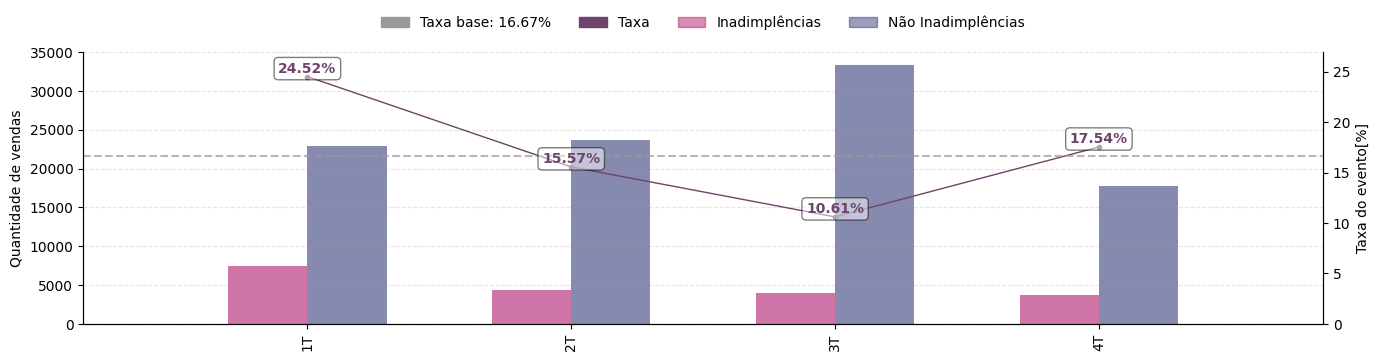

In [77]:
plot_distribuicao_bivariada(df, 'periodo_fiscal', 'default', taxa_inadimplencia, rotation=90, ha='center',show_line_labels=True)

In [78]:
# Criar razão entre valor vencido e valor total pago(+1 para evitar divisão por 0)
df["razao_valor_vencido"] = df["valor_vencido"] / (df["valor_quitado"] + 1)

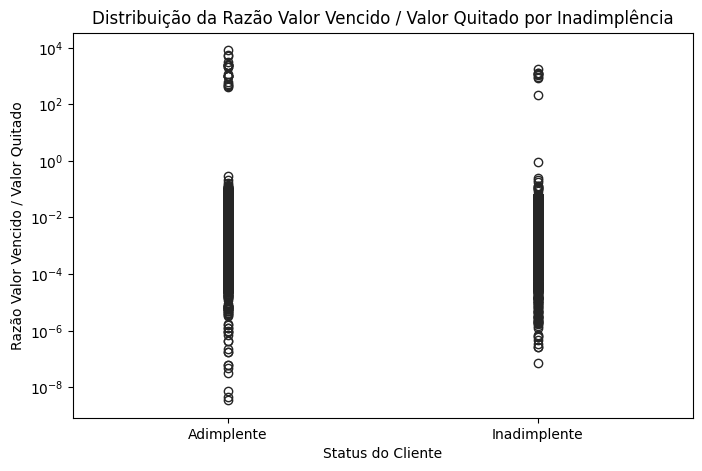

In [79]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["default"], y=df["razao_valor_vencido"], palette=["green", "red"])
plt.xticks([0, 1], ["Adimplente", "Inadimplente"])
plt.title("Distribuição da Razão Valor Vencido / Valor Quitado por Inadimplência")
plt.xlabel("Status do Cliente")
plt.ylabel("Razão Valor Vencido / Valor Quitado")
plt.yscale("log")  # Escala log para visualizar melhor os outliers
plt.show()


In [82]:
# Criar histórico de pagamento como proporção de valores pagos em relação ao vencido
df["historico_pagamento"] = df["valor_quitado"] / (df["valor_quitado"] + df["valor_vencido"] + 1)

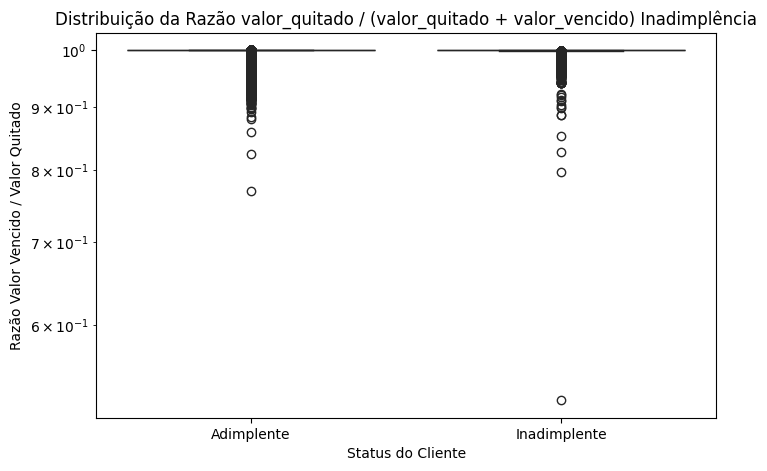

In [87]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["default"], y=df["historico_pagamento"], palette=["green", "red"])
plt.xticks([0, 1], ["Adimplente", "Inadimplente"])
plt.title("Distribuição da Razão valor_quitado / (valor_quitado + valor_vencido) Inadimplência")
plt.xlabel("Status do Cliente")
plt.ylabel("Razão Valor Vencido / Valor Quitado")
plt.yscale("log")  # Escala log para visualizar melhor os outliers
plt.show()
